In [ ]:
!pip3 install pandas

In [ ]:
# Read In Data
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


goalies_df = pd.read_csv('/content/drive/My Drive/Goalies.csv', on_bad_lines="skip")
teams_df = pd.read_csv('/content/drive/My Drive/Teams.csv')

Mounted at /content/drive


In [ ]:
# Merge datasets
merged_df = pd.merge(
    teams_df,
    goalies_df,
    on=['year', 'tmID'],
    how='inner'
)

# 1. Drop unnecessary columns
columns_to_drop = ['lgID_y', 'confID', 'divID', 'franchID', 'name',
                  'PostGP', 'PostMin', 'PostW', 'PostL', 'PostT', 'PostENG',
                  'PostSHO', 'PostGA', 'PostSA', 'playoff', 'rank', 'ENG',
                  'lgID_x', 'GA_y', 'W_x', 'L_x', 'T', 'OTL', 'W_y', 'L_y',
                  'T/OL', 'SoW', 'SoL']
cleaned_df = merged_df.drop(columns=columns_to_drop)

# 2. Rename columns for clarity
cleaned_df = cleaned_df.rename(columns={'GA_x': 'GA'})

# 3. Group by team and year to get team-level statistics
team_stats = cleaned_df.groupby(['year', 'tmID']).agg({
    'G': 'first',          # Games played by team
    'Pts': 'first',        # Team points
    'GF': 'first',         # Goals for
    'GA': 'first',         # Goals against
    'GP': 'sum',           # Total games played by goalies
    'Min': 'sum',          # Total minutes by goalies
    'SHO': 'sum',          # Total shutouts
    'SA': 'sum',           # Total shots against
    'PIM': 'first',        # Penalties in minutes
    'PPG': 'first',        # Power play goals
    'PPC': 'first',        # Power play chances
    'PKG': 'first',        # Penalty kill goals against
    'PKC': 'first'         # Penalty kill chances
}).reset_index()

# 4. Calculate additional metrics
team_stats['SavePercentage'] = (team_stats['SA'] - team_stats['GA']) / team_stats['SA']
team_stats['GoalsAgainstAvg'] = (team_stats['GA'] * 60) / team_stats['Min']

# 5. Handle missing/infinite values
team_stats = team_stats.replace([np.inf, -np.inf], np.nan)

# Prepare features and target
features_to_drop = ['Pts', 'year', 'tmID']
X = team_stats.drop(columns=features_to_drop)
y = team_stats['Pts']

# 1. Remove rows with NaN or infinite values
X = X.replace([np.inf, -np.inf], np.nan)
mask = ~X.isna().any(axis=1)  # Create mask of rows without NaN
X = X[mask]
y = y[mask]


# Rianna Gillies - Code portion

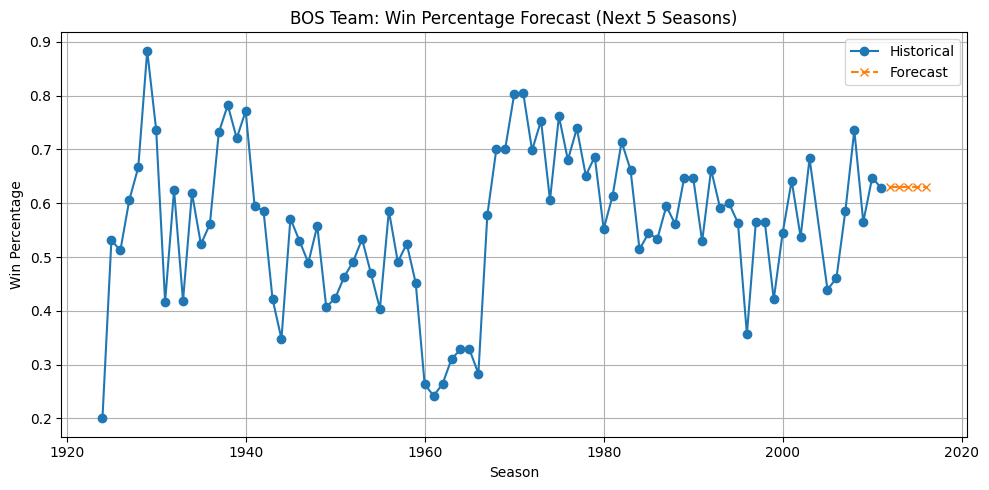

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import time
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

warnings.filterwarnings("ignore")

df = teams_df.copy()

# Get win percentage
df['win_percentage'] = df['W'] / (df['W'] + df['L'])

# Filter only BOS
team_df = df[df['tmID'] == 'BOS'].copy()
team_df = team_df.sort_values('year')
team_df.set_index('year', inplace=True)

# Fit Arima time model
model = ARIMA(team_df['win_percentage'], order=(1, 1, 1))
model_fit = model.fit()

# Forecast next five seasons
forecast_steps = 5
forecast = model_fit.forecast(steps=forecast_steps)
last_season = team_df.index[-1]
forecast_index = [last_season + i for i in range(1, forecast_steps + 1)]

# Plot data
plt.figure(figsize=(10, 5))
plt.plot(team_df['win_percentage'], label="Historical", marker='o')
plt.plot(forecast_index, forecast, label="Forecast", linestyle='--', marker='x')
plt.title("BOS Team: Win Percentage Forecast (Next 5 Seasons)")
plt.xlabel("Season")
plt.ylabel("Win Percentage")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

test_size = 5
train = team_df['win_percentage'][:-test_size]
test = team_df['win_percentage'][-test_size:]

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

# Print results
print(f"Model Performance:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


Model Performance:
MAE:  0.0471
RMSE: 0.0596
